In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import scipy
import os
from scipy.stats import linregress
from datetime import timedelta

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

plt.rcParams['figure.dpi'] = 300

## 1. Load in Data

In [2]:
# LAI data
lai_data_dir = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/field_data'

lai_dates_str = ['20220427', '20220519', '20220526', '20220916']
lai_dates = [datetime.strptime(date, '%Y%m%d') for date in lai_dates_str]

lai_1 = pd.read_csv(os.path.join(lai_data_dir, 'LAI_20220427_20220428.csv'))
lai_2 = pd.read_csv(os.path.join(lai_data_dir, 'LAI_20220518_20220521.csv'))
lai_3 = pd.read_csv(os.path.join(lai_data_dir, 'LAI_20220526_20220527.csv'))
lai_4 = pd.read_csv(os.path.join(lai_data_dir, 'LAI_20220912_20220921_backup.csv'))

lai_list = [lai_1, lai_2, lai_3, lai_4]

# parse the Date and Time column
for lai in lai_list:
    lai['datetime'] = pd.to_datetime(lai['Date and Time'], format='%m/%d/%Y %H:%M')

In [3]:
# LWC, LWP data
fielddata_path = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/field_data/LWC_LFM_WP_dates20230525.csv'

fielddata = pd.read_csv(fielddata_path)

lwp = fielddata[['tree','time','species','date_wp','mpa_mean']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwp['datetime_wp'] = lwp.apply(lambda x: datetime.strptime(str(x['date_wp']),'%Y-%m-%d'), axis=1)

lwa = fielddata[['tree','time','species','date_wp','lwa_g_cm2']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwa['datetime_wp'] = lwa.apply(lambda x: datetime.strptime(str(x['date_wp']),'%Y-%m-%d'), axis=1)

lwc = fielddata[['tree','time','species','date_wp','lwc_mean']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwc['datetime_wp'] = lwc.apply(lambda x: datetime.strptime(str(x['date_wp']),'%Y-%m-%d'), axis=1)

In [4]:
# Defining color cycle to correspond with dates, extended a lil to account for more dates
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_list.append('#000080')
color_list.append('#420303')
color_list.append('#018788')

## 2. Plot Time Series...

In [5]:
lwc

,tree,time,species,date_wp,lwc_mean,datetime_wp
0,2301,md,live oak,2022-02-28,0.728327,2022-02-28
1,2313,pd,blue oak,2022-02-28,0.760753,2022-02-28
2,2331,md,live oak,2022-02-28,0.710632,2022-02-28
3,2343,pd,blue oak,2022-02-28,0.823008,2022-02-28
4,2345,md,live oak,2022-02-28,0.734716,2022-02-28
...,...,...,...,...,...,...
882,2381,md,blue oak,2022-09-15,0.582908,2022-09-15
883,2382,pd,blue oak,2022-09-15,0.674750,2022-09-15
884,2383,md,blue oak,2022-09-15,0.578622,2022-09-15
885,2383,pd,blue oak,2022-09-15,1.067080,2022-09-15


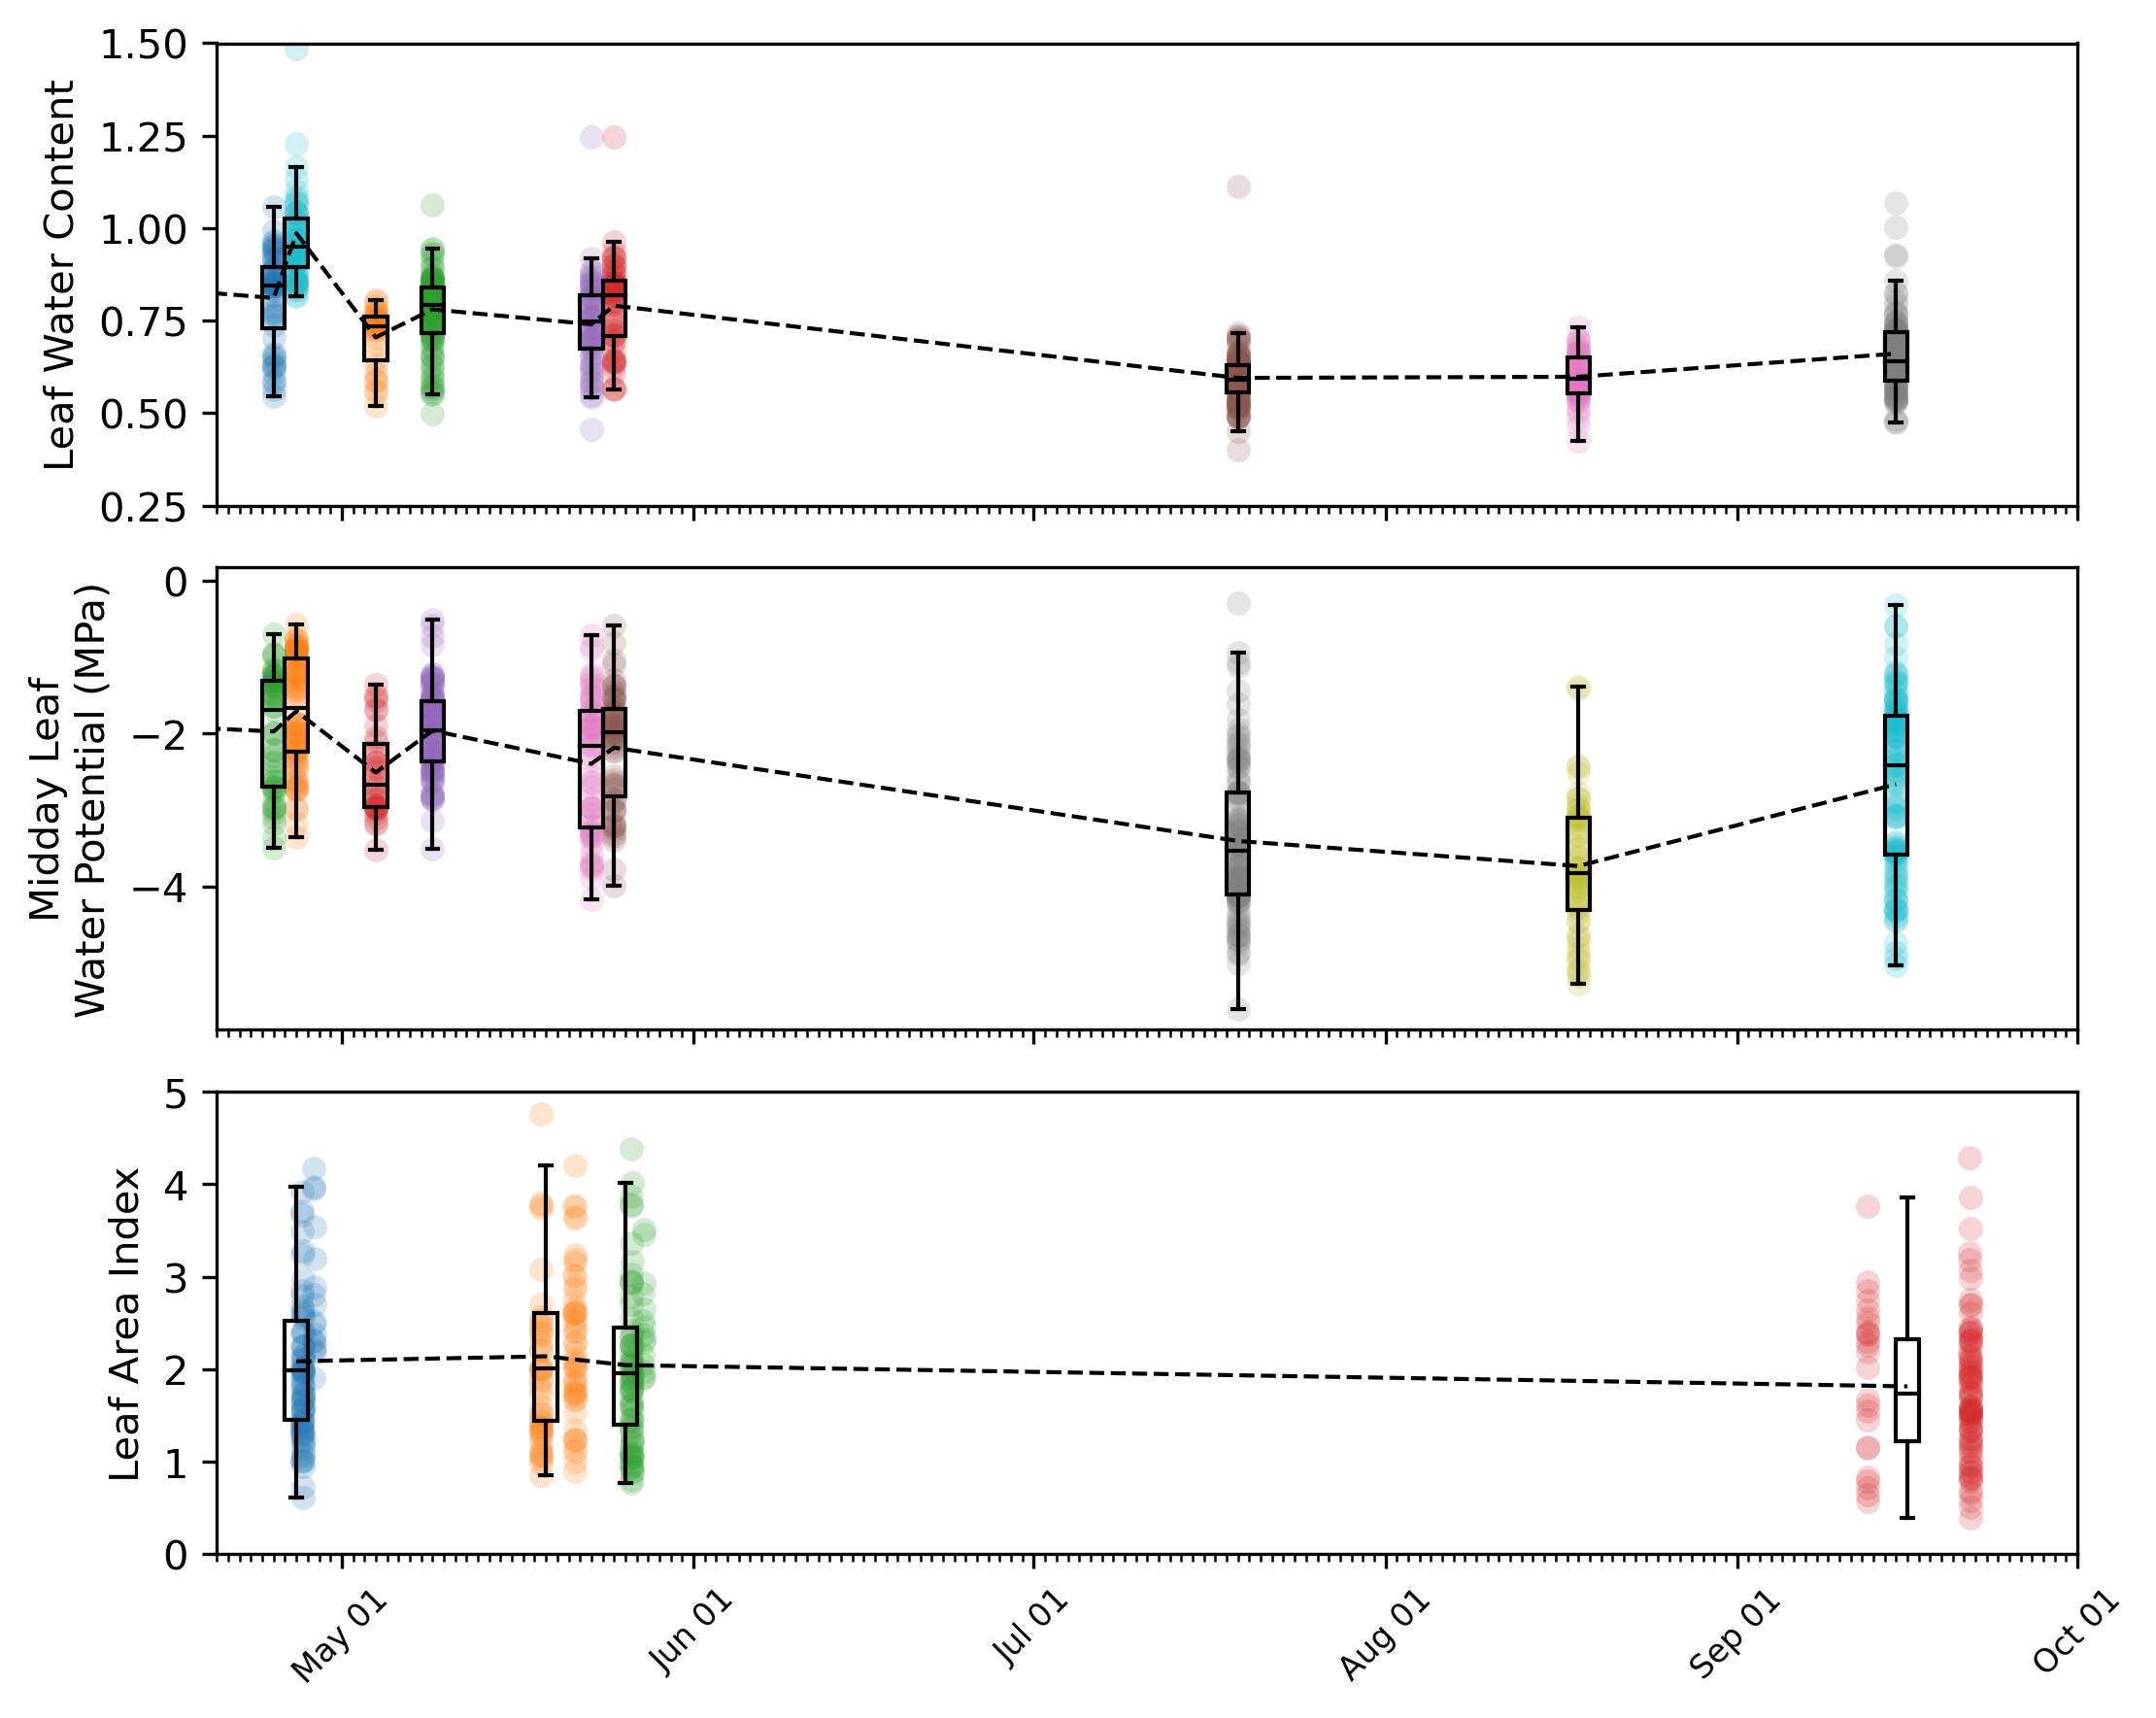

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(7.5, 6), sharex=True)


# LWC
for date in lwc['datetime_wp'].unique():
    lwc_date = lwc[lwc['datetime_wp'] == date]
    axs[0].scatter(lwc_date['datetime_wp'], lwc_date['lwc_mean'], alpha=0.2, linewidth=0)
lwc_dates = lwc['datetime_wp'].unique()
lwc_dates.sort()
lwc_vals = [lwc[lwc['datetime_wp'] == date]['lwc_mean'].dropna().values for date in lwc_dates]
lwc_dates_num = mdates.date2num(lwc_dates)
axs[0].boxplot(lwc_vals, positions=lwc_dates_num, widths=2, patch_artist=True, showfliers=False, boxprops=dict(facecolor='#FF000000', color='#000000'), medianprops=dict(color='#000000'))
mean_lwcs = [lwc[lwc['datetime_wp'] == date]['lwc_mean'].mean() for date in lwc_dates]
axs[0].plot(lwc_dates, mean_lwcs, color='black', linestyle='--', linewidth=1)
axs[0].set_ylabel('Leaf Water Content')
axs[0].set_ylim(0.25, 1.5)

# Midday LWP
for date in lwp['datetime_wp'].unique():
    lwp_date = lwp[lwp['datetime_wp'] == date]
    axs[1].scatter(lwp_date['datetime_wp'], -1*lwp_date['mpa_mean'], alpha=0.2, linewidth=0)
lwp_dates = lwp['datetime_wp'].unique()
lwp_dates.sort()
lwp_vals = [lwp[lwp['datetime_wp'] == date]['mpa_mean'].dropna().values * -1 for date in lwp_dates]
lwp_dates_num = mdates.date2num(lwp_dates)
axs[1].boxplot(lwp_vals, positions=lwp_dates_num, widths=2, patch_artist=True, showfliers=False, boxprops=dict(facecolor='#FF000000', color='#000000'), medianprops=dict(color='#000000'))
mean_lwps = [-1*lwp[lwp['datetime_wp'] == date]['mpa_mean'].mean() for date in lwp_dates]
axs[1].plot(lwp_dates, mean_lwps, color='black', linestyle='--', linewidth=1)
axs[1].set_ylabel('Midday Leaf\nWater Potential (MPa)')

# LAI
for lai, date in zip(lai_list, lai_dates):
    axs[2].scatter(lai['datetime'], lai['LAI'], alpha=0.2, linewidth=0, color=color_list[lai_dates.index(date)])
lai_vals = [lai['LAI'].values for lai in lai_list]
lai_dates_num = mdates.date2num(lai_dates)
axs[2].boxplot(lai_vals, positions=lai_dates_num, widths=2, patch_artist=True, showfliers=False, boxprops=dict(facecolor='#FF000000', color='#000000'), medianprops=dict(color='#000000'))
mean_lais = [lai['LAI'].mean() for lai in lai_list]
axs[2].plot(lai_dates, mean_lais, color='black', linestyle='--', linewidth=1)
axs[2].set_ylabel('Leaf Area Index')
axs[2].set_ylim(0, 5)

# Set x-axis to date format
for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_tick_params(rotation=45)
    ax.xaxis.set_tick_params(which='minor', rotation=45)
    ax.xaxis.set_tick_params(which='minor', labelsize=8)
    ax.xaxis.set_tick_params(which='major', labelsize=8)
    ax.xaxis.set_tick_params(which='major', rotation=45)

axs[0].set_xlim([datetime(2022, 4, 20), datetime(2022, 10, 1)])

plt.tight_layout()
# plt.savefig('./field_data_timeseries.png', dpi=300)
plt.show()